In [150]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import heapq
import random
from tqdm import tqdm
import os
import pickle
import warnings

warnings.filterwarnings('ignore')

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
class GraphDatasetGenerator:
    def __init__(self, min_nodes=10, max_nodes=100, edge_probability=0.3):
        self.min_nodes = min_nodes
        self.max_nodes = max_nodes
        self.edge_probability = edge_probability

    def generate_random_graph(self, num_nodes):
        adj_matrix = np.zeros((num_nodes, num_nodes))
        for i in range(1, num_nodes):
            parent = random.randint(0, i - 1)
            weight = random.uniform(1, 10)
            adj_matrix[i][parent] = weight
            adj_matrix[parent][i] = weight
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if adj_matrix[i][j] == 0 and random.random() < self.edge_probability:
                    weight = random.uniform(1, 10)
                    adj_matrix[i][j] = weight
                    adj_matrix[j][i] = weight
        return adj_matrix

    def dijkstra_algorithm(self, adj_matrix, start, end):
        num_nodes = len(adj_matrix)
        distances = {node: float('inf') for node in range(num_nodes)}
        distances[start] = 0
        previous_nodes = {node: None for node in range(num_nodes)}
        pq = [(0, start)]
        while pq:
            current_distance, current_node = heapq.heappop(pq)
            if current_distance > distances[current_node]:
                continue
            if current_node == end:
                break
            for neighbor, weight in enumerate(adj_matrix[current_node]):
                if weight > 0:
                    distance = current_distance + weight
                    if distance < distances[neighbor]:
                        distances[neighbor] = distance
                        previous_nodes[neighbor] = current_node
                        heapq.heappush(pq, (distance, neighbor))
        path, current_node = [], end
        while previous_nodes.get(current_node) is not None:
            path.insert(0, current_node)
            current_node = previous_nodes[current_node]
        if path or start == end:
            if not path or path[0] != start:
                path.insert(0, start)

        if distances[end] == float('inf'):
            return float('inf'), []
            
        return distances[end], path

    def generate_dataset(self, num_samples=1000):
        dataset = []
        print(f"Generating {num_samples} graph samples...")
        for _ in tqdm(range(num_samples)):
            num_nodes = random.randint(self.min_nodes, self.max_nodes)
            adj_matrix = self.generate_random_graph(num_nodes)
            for _ in range(3):  # 3 samples per graph
                start, end = random.sample(range(num_nodes), 2)
                distance, path = self.dijkstra_algorithm(adj_matrix, start, end)
                if distance != float('inf'):
                    dataset.append({
                        'adj_matrix': adj_matrix.copy(),
                        'start': start, 'end': end,
                        'distance': distance, 'path': path
                    })
        return dataset


In [ ]:
class GraphPathGNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=1):
        super(GraphPathGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        
        self.distance_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )
        
        self.path_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2), nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x_embeddings = self.dropout(F.relu(self.conv3(x, edge_index, edge_attr)))
        
        start_nodes = (data.x[:, 1] == 1).nonzero(as_tuple=True)[0]
        end_nodes = (data.x[:, 2] == 1).nonzero(as_tuple=True)[0]
        start_embeddings = x_embeddings[start_nodes]
        end_embeddings = x_embeddings[end_nodes]
        combined_embeddings = torch.cat([start_embeddings, end_embeddings], dim=1)
        predicted_distance = self.distance_predictor(combined_embeddings)
        
        predicted_path_logits = self.path_classifier(x_embeddings)
        
        return predicted_distance, predicted_path_logits

In [ ]:
class ReinforcementLearningTrainer:
    """Trainer for the dual-head GNN."""
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=5, factor=0.5)
        self.path_loss_fn = nn.BCEWithLogitsLoss()

    def calculate_reward(self, predicted_dist, true_dist):
        error = torch.abs(predicted_dist - true_dist) / (true_dist + 1e-6)
        return 1.0 / (1.0 + error)

    def train_step(self, batch):
        self.model.train()
    
        pred_dist, pred_path_logits = self.model(batch)
        pred_dist = pred_dist.squeeze()
        pred_path_logits = pred_path_logits.squeeze()
    
        true_dist = batch.y_dist
        true_path = batch.y_path
    
        reward = self.calculate_reward(pred_dist, true_dist)
        loss_dist = F.mse_loss(pred_dist, true_dist) - (reward.mean() * 0.05)
    
        loss_path = self.path_loss_fn(pred_path_logits, true_path.float())
    
        total_loss = loss_dist + 0.5 * loss_path
    
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
    
        return total_loss.item(), loss_dist.item(), loss_path.item()


In [ ]:
class GraphPathPredictor:
    def __init__(self, min_nodes=10, max_nodes=50, device='cpu'):
        self.generator = GraphDatasetGenerator(min_nodes, max_nodes)
        self.device = torch.device(device)
        self.model = GraphPathGNN().to(self.device)
        self.rl_trainer = ReinforcementLearningTrainer(self.model)
        self.dataset = None
        self.train_loader = None
        self.test_loader = None

    @staticmethod
    def collate_fn(data_list):
        batch = Batch.from_data_list(data_list)
        distances = torch.cat([data.y_dist for data in data_list])
        batch.y_dist = distances
        return batch


    def prepare_torch_data(self, sample):
        adj = sample['adj_matrix']
        num_nodes = len(adj)
    
        degree = (adj > 0).sum(axis=1)
        normalized_degree = degree / (np.max(degree) if np.max(degree) > 0 else 1)
    
        rows, cols = np.where(adj > 0)
        edge_index = torch.tensor([rows, cols], dtype=torch.long)
        edge_attr = torch.tensor(adj[rows, cols], dtype=torch.float)
    
        x = torch.zeros(num_nodes, 3, dtype=torch.float)
        x[:, 0] = torch.from_numpy(normalized_degree)  
        x[sample['start'], 1] = 1.0                    
        x[sample['end'], 2] = 1.0                      
    
        path_labels = torch.zeros(num_nodes, dtype=torch.float)
        if sample['path']:
            for node in sample['path']:
                path_labels[node] = 1.0
    
        return Data(
            x=x, 
            edge_index=edge_index, 
            edge_attr=edge_attr,
            y_dist=torch.tensor([sample['distance']], dtype=torch.float),
            y_path=path_labels
        )

    def create_dataset(self, num_samples=2000, batch_size=32, force_generate=False):
        dataset_file = 'dataset_v3.pkl'
        if os.path.exists(dataset_file) and not force_generate:
            print(f"Loading cached dataset from {dataset_file}...")
            with open(dataset_file, 'rb') as f:
                self.dataset = pickle.load(f)
        else:
            print("Creating new dataset...")
            raw_dataset = self.generator.generate_dataset(num_samples)
            self.dataset = [self.prepare_torch_data(s) for s in raw_dataset]
            with open(dataset_file, 'wb') as f:
                pickle.dump(self.dataset, f)
    
        print(f"Dataset created with {len(self.dataset)} samples")
    
        train_data, test_data = train_test_split(self.dataset, test_size=0.2, random_state=42)
        num_workers = 0
        print(f"Using {num_workers} workers for DataLoader.")

        self.train_loader = DataLoader(
            train_data, 
            batch_size=batch_size, 
            shuffle=True, 
            collate_fn=self.collate_fn,
            num_workers=num_workers
        )
        self.test_loader = DataLoader(
            test_data, 
            batch_size=batch_size, 
            shuffle=False, 
            collate_fn=self.collate_fn,
            num_workers=num_workers
        )
    
        print(f"Train set: {len(train_data)} samples, Test set: {len(test_data)} samples")

    def train_model(self, epochs=100, patience=15):
        print("\n--- Starting Training ---")
        best_loss = float('inf')
        patience_counter = 0
    
        for epoch in range(epochs):
            self.model.train()
            total_loss, total_dist_loss, total_path_loss = 0, 0, 0
            for batch in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                batch = batch.to(self.device)
                loss, dist_loss, path_loss = self.rl_trainer.train_step(batch)
                total_loss += loss
                total_dist_loss += dist_loss
                total_path_loss += path_loss
        
            avg_loss = total_loss / len(self.train_loader)
            avg_dist_loss = total_dist_loss / len(self.train_loader)
            avg_path_loss = total_path_loss / len(self.train_loader)
            self.rl_trainer.scheduler.step(avg_loss)
        
            print(f"Epoch {epoch+1}: Avg Loss={avg_loss:.4f} (Dist: {avg_dist_loss:.4f}, Path: {avg_path_loss:.4f})")
        
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
    
    def evaluate_model(self):
        print("\n--- Evaluating Model ---")
        self.model.load_state_dict(torch.load('best_model.pth'))
        self.model.eval()
        preds, truths = [], []
    
        with torch.no_grad():
            for batch in self.test_loader:
                batch = batch.to(self.device)
                pred_dist, _ = self.model(batch)  
                preds.extend(pred_dist.cpu().numpy().flatten())
                truths.extend(batch.y_dist.cpu().numpy().flatten())  
    
        mse = mean_squared_error(truths, preds)
        tolerance = 0.1
        accurate_count = sum(1 for p, t in zip(preds, truths) if t > 0 and abs(p - t) / t < tolerance)
        accuracy = accurate_count / len(preds) if preds else 0
    
        print(f"Test MSE: {mse:.4f}")
        print(f"Test Accuracy (within {tolerance*100}%): {accuracy:.4f}")
        self.plot_predictions(preds, truths)
        return mse, accuracy


    def predict_path(self, adj_matrix, start_node, end_node):
        self.model.eval()
        sample = {'adj_matrix': adj_matrix, 'start': start_node, 'end': end_node, 'distance': 0, 'path': []}
        data = self.prepare_torch_data(sample).to(self.device)
        batch = Batch.from_data_list([data]).to(self.device)
    
        with torch.no_grad():
            pred_dist, pred_path_logits = self.model(batch)
            prediction = pred_dist.item()
        
        true_distance, true_path = self.generator.dijkstra_algorithm(adj_matrix, start_node, end_node)
        return prediction, true_distance, true_path


    def visualize_dataset_sample(self, index=0):
        print(f"\n--- Visualizing Dataset Sample #{index} ---")
        if not self.dataset or index >= len(self.dataset):
            print("Dataset not created or index out of bounds.")
            return

        data_sample = self.dataset[index]
        num_nodes = data_sample.num_nodes
        adj_matrix = np.zeros((num_nodes, num_nodes))
        edge_index = data_sample.edge_index.cpu().numpy()
        edge_attr = data_sample.edge_attr.cpu().numpy()
        
        for i in range(edge_index.shape[1]):
            u, v = edge_index[:, i]
            adj_matrix[u, v] = edge_attr[i]

        start_node = (data_sample.x[:, 1] == 1).nonzero(as_tuple=True)[0].item()
        end_node = (data_sample.x[:, 2] == 1).nonzero(as_tuple=True)[0].item()
        _, path = self.generator.dijkstra_algorithm(adj_matrix, start_node, end_node)
        self.plot_graph_with_path(adj_matrix, start_node, end_node, path)


    @staticmethod
    def plot_training_curves(history):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(history['loss'], label='Loss')
        ax1.set_title('Training Loss per Epoch'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True)
        ax2.plot(history['reward'], label='Reward', color='orange')
        ax2.set_title('Training Reward per Epoch'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Average Reward'); ax2.grid(True)
        plt.tight_layout(); plt.show()

    @staticmethod
    def plot_predictions(predictions, ground_truths):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(ground_truths, predictions, alpha=0.6, edgecolors='w', linewidth=0.5)
        plt.plot([min(ground_truths), max(ground_truths)], [min(ground_truths), max(ground_truths)], 'r--', label='Ideal')
        plt.xlabel('Ground Truth Distance'); plt.ylabel('Predicted Distance'); plt.title('Predictions vs. Ground Truth'); plt.grid(True)
        
        plt.subplot(1, 2, 2)
        errors = [abs(p - t) / t for p, t in zip(predictions, ground_truths) if t > 0]
        plt.hist(errors, bins=50, alpha=0.75, color='g')
        plt.xlabel('Relative Error'); plt.ylabel('Frequency'); plt.title('Distribution of Relative Errors'); plt.grid(True)
        plt.tight_layout(); plt.show()

    def plot_graph_with_path(self, adj_matrix, start_node, end_node, path):
        G = nx.from_numpy_array(adj_matrix)
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(12, 8))
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
        nx.draw_networkx_edges(G, pos, alpha=0.5)
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='lightgreen', node_size=700)
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='green', width=2.5)
        nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='tomato', node_size=700, label='Start')
        nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color='gold', node_size=700, label='End')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        for k, v in edge_labels.items():
            edge_labels[k] = round(v, 1)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title(f"Shortest Path from Node {start_node} to {end_node}", size=15)
        plt.show()

In [ ]:
def main():
    print("=== GNN Path Prediction with Reinforcement Learning ===")
    
    NUM_SAMPLES = 5000
    EPOCHS = 100
    PATIENCE = 10
    MIN_NODES = 15
    MAX_NODES = 40
    FORCE_REGENERATE_DATASET = True 
    
    predictor = GraphPathPredictor(min_nodes=MIN_NODES, max_nodes=MAX_NODES)
    
    predictor.create_dataset(num_samples=NUM_SAMPLES, force_generate=FORCE_REGENERATE_DATASET)
    predictor.visualize_dataset_sample(index=0)
    
    predictor.train_model(epochs=EPOCHS, patience=PATIENCE)
    
    predictor.evaluate_model()
    
    print("\n--- Testing with Custom Example ---")
    test_adj = np.array([
        [0, 2, 4, 0, 0, 0],
        [2, 0, 1, 7, 0, 0],
        [4, 1, 0, 3, 5, 0],
        [0, 7, 3, 0, 1, 9],
        [0, 0, 5, 1, 0, 2],
        [0, 0, 0, 9, 2, 0]
    ])
    start, end = 0, 5
    
    predicted_dist, true_dist, true_path = predictor.predict_path(test_adj, start, end)
    
    print(f"Start node: {start}, End node: {end}")
    print(f"Predicted distance: {predicted_dist:.4f}")
    print(f"True distance (Dijkstra): {true_dist:.4f}")
    
    if true_path:
        predictor.plot_graph_with_path(test_adj, start, end, true_path)
    
    torch.save(predictor.model.state_dict(), 'final_gnn_model.pth')
    print("\nFinal model saved as 'final_gnn_model.pth'")
    
    return predictor


=== GNN Path Prediction with Reinforcement Learning ===
Creating new dataset...
Generating 5000 graph samples...


100%|██████████| 5000/5000 [00:07<00:00, 650.85it/s]


Dataset created with 15000 samples
Using 0 workers for DataLoader.
Train set: 12000 samples, Test set: 3000 samples

--- Visualizing Dataset Sample #0 ---


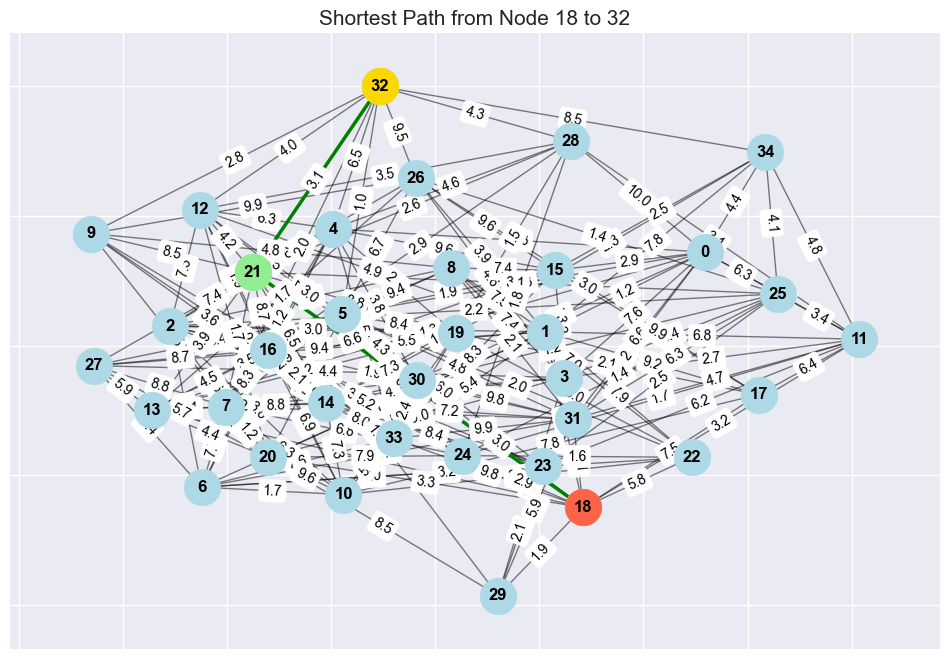


--- Starting Training ---


Epoch 1/100: 100%|██████████| 375/375 [00:33<00:00, 11.12it/s]


Epoch 1: Avg Loss=8.9203 (Dist: 8.7291, Path: 0.3824)


Epoch 2/100: 100%|██████████| 375/375 [00:33<00:00, 11.33it/s]


Epoch 2: Avg Loss=6.5342 (Dist: 6.3503, Path: 0.3678)


Epoch 3/100: 100%|██████████| 375/375 [00:34<00:00, 10.78it/s]


Epoch 3: Avg Loss=5.9531 (Dist: 5.7696, Path: 0.3669)


Epoch 4/100: 100%|██████████| 375/375 [00:33<00:00, 11.25it/s]


Epoch 4: Avg Loss=5.7014 (Dist: 5.5187, Path: 0.3654)


Epoch 5/100: 100%|██████████| 375/375 [00:32<00:00, 11.43it/s]


Epoch 5: Avg Loss=5.5122 (Dist: 5.3302, Path: 0.3641)


Epoch 6/100: 100%|██████████| 375/375 [00:33<00:00, 11.14it/s]


Epoch 6: Avg Loss=5.3360 (Dist: 5.1541, Path: 0.3639)


Epoch 7/100: 100%|██████████| 375/375 [00:32<00:00, 11.38it/s]


Epoch 7: Avg Loss=5.2483 (Dist: 5.0668, Path: 0.3631)


Epoch 8/100: 100%|██████████| 375/375 [00:33<00:00, 11.26it/s]


Epoch 8: Avg Loss=5.0281 (Dist: 4.8469, Path: 0.3625)


Epoch 9/100: 100%|██████████| 375/375 [00:33<00:00, 11.15it/s]


Epoch 9: Avg Loss=5.1153 (Dist: 4.9343, Path: 0.3620)


Epoch 10/100: 100%|██████████| 375/375 [00:33<00:00, 11.26it/s]


Epoch 10: Avg Loss=5.0458 (Dist: 4.8650, Path: 0.3616)


Epoch 11/100: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


Epoch 11: Avg Loss=4.9750 (Dist: 4.7947, Path: 0.3605)


Epoch 12/100: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


Epoch 12: Avg Loss=4.8262 (Dist: 4.6464, Path: 0.3596)


Epoch 13/100: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


Epoch 13: Avg Loss=5.0212 (Dist: 4.8417, Path: 0.3588)


Epoch 14/100: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


Epoch 14: Avg Loss=4.8796 (Dist: 4.7005, Path: 0.3582)


Epoch 15/100: 100%|██████████| 375/375 [00:32<00:00, 11.47it/s]


Epoch 15: Avg Loss=4.6504 (Dist: 4.4720, Path: 0.3566)


Epoch 16/100: 100%|██████████| 375/375 [00:33<00:00, 11.16it/s]


Epoch 16: Avg Loss=4.8202 (Dist: 4.6421, Path: 0.3562)


Epoch 17/100: 100%|██████████| 375/375 [00:32<00:00, 11.42it/s]


Epoch 17: Avg Loss=4.7558 (Dist: 4.5788, Path: 0.3541)


Epoch 18/100: 100%|██████████| 375/375 [00:31<00:00, 11.79it/s]


Epoch 18: Avg Loss=4.6294 (Dist: 4.4528, Path: 0.3533)


Epoch 19/100: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


Epoch 19: Avg Loss=4.5403 (Dist: 4.3648, Path: 0.3511)


Epoch 20/100: 100%|██████████| 375/375 [00:35<00:00, 10.70it/s]


Epoch 20: Avg Loss=4.5332 (Dist: 4.3586, Path: 0.3493)


Epoch 21/100: 100%|██████████| 375/375 [00:35<00:00, 10.66it/s]


Epoch 21: Avg Loss=4.5619 (Dist: 4.3881, Path: 0.3475)


Epoch 22/100: 100%|██████████| 375/375 [00:39<00:00,  9.44it/s]


Epoch 22: Avg Loss=4.4564 (Dist: 4.2841, Path: 0.3446)


Epoch 23/100: 100%|██████████| 375/375 [00:42<00:00,  8.87it/s]


Epoch 23: Avg Loss=4.4471 (Dist: 4.2756, Path: 0.3430)


Epoch 24/100: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


Epoch 24: Avg Loss=4.4161 (Dist: 4.2460, Path: 0.3401)


Epoch 25/100: 100%|██████████| 375/375 [00:40<00:00,  9.22it/s]


Epoch 25: Avg Loss=4.3041 (Dist: 4.1354, Path: 0.3374)


Epoch 26/100: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


Epoch 26: Avg Loss=4.1325 (Dist: 3.9663, Path: 0.3324)


Epoch 27/100: 100%|██████████| 375/375 [00:44<00:00,  8.39it/s]


Epoch 27: Avg Loss=4.0875 (Dist: 3.9220, Path: 0.3309)


Epoch 28/100: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


Epoch 28: Avg Loss=4.0807 (Dist: 3.9177, Path: 0.3259)


Epoch 29/100: 100%|██████████| 375/375 [00:42<00:00,  8.77it/s]


Epoch 29: Avg Loss=3.9667 (Dist: 3.8055, Path: 0.3223)


Epoch 30/100: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


Epoch 30: Avg Loss=3.8409 (Dist: 3.6814, Path: 0.3190)


Epoch 31/100: 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]


Epoch 31: Avg Loss=3.7726 (Dist: 3.6158, Path: 0.3136)


Epoch 32/100: 100%|██████████| 375/375 [00:34<00:00, 10.87it/s]


Epoch 32: Avg Loss=3.7864 (Dist: 3.6324, Path: 0.3080)


Epoch 33/100: 100%|██████████| 375/375 [00:50<00:00,  7.49it/s]


Epoch 33: Avg Loss=3.8093 (Dist: 3.6570, Path: 0.3045)


Epoch 34/100: 100%|██████████| 375/375 [00:34<00:00, 10.76it/s]


Epoch 34: Avg Loss=3.7040 (Dist: 3.5529, Path: 0.3021)


Epoch 35/100: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


Epoch 35: Avg Loss=3.6967 (Dist: 3.5477, Path: 0.2979)


Epoch 36/100: 100%|██████████| 375/375 [00:35<00:00, 10.70it/s]


Epoch 36: Avg Loss=3.7107 (Dist: 3.5624, Path: 0.2967)


Epoch 37/100: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


Epoch 37: Avg Loss=3.6013 (Dist: 3.4551, Path: 0.2925)


Epoch 38/100: 100%|██████████| 375/375 [00:33<00:00, 11.29it/s]


Epoch 38: Avg Loss=3.5338 (Dist: 3.3899, Path: 0.2877)


Epoch 39/100: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


Epoch 39: Avg Loss=3.5448 (Dist: 3.4013, Path: 0.2871)


Epoch 40/100: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


Epoch 40: Avg Loss=3.5369 (Dist: 3.3942, Path: 0.2854)


Epoch 41/100: 100%|██████████| 375/375 [00:34<00:00, 10.80it/s]


Epoch 41: Avg Loss=3.4890 (Dist: 3.3477, Path: 0.2825)


Epoch 42/100: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


Epoch 42: Avg Loss=3.4574 (Dist: 3.3173, Path: 0.2801)


Epoch 43/100: 100%|██████████| 375/375 [00:45<00:00,  8.19it/s]


Epoch 43: Avg Loss=3.4827 (Dist: 3.3440, Path: 0.2775)


Epoch 44/100: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


Epoch 44: Avg Loss=3.4291 (Dist: 3.2928, Path: 0.2727)


Epoch 45/100: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


Epoch 45: Avg Loss=3.4544 (Dist: 3.3177, Path: 0.2733)


Epoch 46/100: 100%|██████████| 375/375 [00:33<00:00, 11.13it/s]


Epoch 46: Avg Loss=3.4049 (Dist: 3.2703, Path: 0.2692)


Epoch 47/100: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


Epoch 47: Avg Loss=3.3509 (Dist: 3.2163, Path: 0.2692)


Epoch 48/100: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s]


Epoch 48: Avg Loss=3.4025 (Dist: 3.2688, Path: 0.2675)


Epoch 49/100: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]


Epoch 49: Avg Loss=3.3798 (Dist: 3.2486, Path: 0.2624)


Epoch 50/100: 100%|██████████| 375/375 [00:42<00:00,  8.82it/s]


Epoch 50: Avg Loss=3.3857 (Dist: 3.2558, Path: 0.2599)


Epoch 51/100: 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]


Epoch 51: Avg Loss=3.3634 (Dist: 3.2351, Path: 0.2567)


Epoch 52/100: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


Epoch 52: Avg Loss=3.3532 (Dist: 3.2260, Path: 0.2543)


Epoch 53/100: 100%|██████████| 375/375 [00:54<00:00,  6.87it/s]


Epoch 53: Avg Loss=3.3017 (Dist: 3.1758, Path: 0.2518)


Epoch 54/100: 100%|██████████| 375/375 [00:44<00:00,  8.39it/s]


Epoch 54: Avg Loss=3.3123 (Dist: 3.1887, Path: 0.2471)


Epoch 55/100: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


Epoch 55: Avg Loss=3.2831 (Dist: 3.1591, Path: 0.2479)


Epoch 56/100: 100%|██████████| 375/375 [00:43<00:00,  8.68it/s]


Epoch 56: Avg Loss=3.2948 (Dist: 3.1715, Path: 0.2467)


Epoch 57/100: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


Epoch 57: Avg Loss=3.2362 (Dist: 3.1145, Path: 0.2433)


Epoch 58/100: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


Epoch 58: Avg Loss=3.2797 (Dist: 3.1594, Path: 0.2406)


Epoch 59/100: 100%|██████████| 375/375 [00:45<00:00,  8.27it/s]


Epoch 59: Avg Loss=3.2856 (Dist: 3.1655, Path: 0.2401)


Epoch 60/100: 100%|██████████| 375/375 [01:06<00:00,  5.67it/s]


Epoch 60: Avg Loss=3.2643 (Dist: 3.1463, Path: 0.2360)


Epoch 61/100: 100%|██████████| 375/375 [00:54<00:00,  6.91it/s]


Epoch 61: Avg Loss=3.2769 (Dist: 3.1590, Path: 0.2358)


Epoch 62/100: 100%|██████████| 375/375 [00:39<00:00,  9.48it/s]


Epoch 62: Avg Loss=3.2204 (Dist: 3.1031, Path: 0.2347)


Epoch 63/100: 100%|██████████| 375/375 [01:08<00:00,  5.47it/s]


Epoch 63: Avg Loss=3.2427 (Dist: 3.1260, Path: 0.2333)


Epoch 64/100: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


Epoch 64: Avg Loss=3.2190 (Dist: 3.1029, Path: 0.2322)


Epoch 65/100: 100%|██████████| 375/375 [00:54<00:00,  6.86it/s]


Epoch 65: Avg Loss=3.2835 (Dist: 3.1685, Path: 0.2300)


Epoch 66/100: 100%|██████████| 375/375 [00:52<00:00,  7.18it/s]


Epoch 66: Avg Loss=3.2576 (Dist: 3.1437, Path: 0.2278)


Epoch 67/100: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


Epoch 67: Avg Loss=3.2525 (Dist: 3.1378, Path: 0.2294)


Epoch 68/100: 100%|██████████| 375/375 [00:51<00:00,  7.27it/s]


Epoch 68: Avg Loss=3.1899 (Dist: 3.0768, Path: 0.2263)


Epoch 69/100: 100%|██████████| 375/375 [00:50<00:00,  7.39it/s]


Epoch 69: Avg Loss=3.2759 (Dist: 3.1636, Path: 0.2247)


Epoch 70/100: 100%|██████████| 375/375 [00:41<00:00,  9.05it/s]


Epoch 70: Avg Loss=3.1532 (Dist: 3.0418, Path: 0.2228)


Epoch 71/100: 100%|██████████| 375/375 [00:45<00:00,  8.23it/s]


Epoch 71: Avg Loss=3.2585 (Dist: 3.1459, Path: 0.2252)


Epoch 72/100: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


Epoch 72: Avg Loss=3.2717 (Dist: 3.1604, Path: 0.2226)


Epoch 73/100: 100%|██████████| 375/375 [00:46<00:00,  8.06it/s]


Epoch 73: Avg Loss=3.2127 (Dist: 3.1028, Path: 0.2197)


Epoch 74/100: 100%|██████████| 375/375 [01:01<00:00,  6.15it/s]


Epoch 74: Avg Loss=3.1954 (Dist: 3.0851, Path: 0.2206)


Epoch 75/100: 100%|██████████| 375/375 [01:21<00:00,  4.62it/s]


Epoch 75: Avg Loss=3.1827 (Dist: 3.0735, Path: 0.2184)


Epoch 76/100: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


Epoch 76: Avg Loss=3.1153 (Dist: 3.0069, Path: 0.2168)


Epoch 77/100: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


Epoch 77: Avg Loss=3.2113 (Dist: 3.1031, Path: 0.2164)


Epoch 78/100: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


Epoch 78: Avg Loss=3.1778 (Dist: 3.0702, Path: 0.2151)


Epoch 79/100: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


Epoch 79: Avg Loss=3.2135 (Dist: 3.1059, Path: 0.2152)


Epoch 80/100: 100%|██████████| 375/375 [00:45<00:00,  8.31it/s]


Epoch 80: Avg Loss=3.1410 (Dist: 3.0341, Path: 0.2138)


Epoch 81/100: 100%|██████████| 375/375 [00:46<00:00,  8.12it/s]


Epoch 81: Avg Loss=3.1908 (Dist: 3.0829, Path: 0.2158)


Epoch 82/100: 100%|██████████| 375/375 [00:35<00:00, 10.62it/s]


Epoch 82: Avg Loss=3.1407 (Dist: 3.0341, Path: 0.2132)


Epoch 83/100: 100%|██████████| 375/375 [00:35<00:00, 10.64it/s]


Epoch 83: Avg Loss=3.0531 (Dist: 2.9479, Path: 0.2104)


Epoch 84/100: 100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


Epoch 84: Avg Loss=3.0468 (Dist: 2.9422, Path: 0.2091)


Epoch 85/100: 100%|██████████| 375/375 [00:36<00:00, 10.35it/s]


Epoch 85: Avg Loss=3.1072 (Dist: 3.0030, Path: 0.2085)


Epoch 86/100: 100%|██████████| 375/375 [00:34<00:00, 11.02it/s]


Epoch 86: Avg Loss=3.0503 (Dist: 2.9472, Path: 0.2061)


Epoch 87/100: 100%|██████████| 375/375 [00:33<00:00, 11.12it/s]


Epoch 87: Avg Loss=3.0411 (Dist: 2.9379, Path: 0.2065)


Epoch 88/100: 100%|██████████| 375/375 [00:36<00:00, 10.39it/s]


Epoch 88: Avg Loss=3.0440 (Dist: 2.9407, Path: 0.2067)


Epoch 89/100: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


Epoch 89: Avg Loss=3.0090 (Dist: 2.9064, Path: 0.2052)


Epoch 90/100: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


Epoch 90: Avg Loss=3.0403 (Dist: 2.9376, Path: 0.2054)


Epoch 91/100: 100%|██████████| 375/375 [00:35<00:00, 10.67it/s]


Epoch 91: Avg Loss=3.0348 (Dist: 2.9322, Path: 0.2051)


Epoch 92/100: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


Epoch 92: Avg Loss=3.0559 (Dist: 2.9533, Path: 0.2052)


Epoch 93/100: 100%|██████████| 375/375 [00:34<00:00, 10.75it/s]


Epoch 93: Avg Loss=3.0358 (Dist: 2.9333, Path: 0.2050)


Epoch 94/100: 100%|██████████| 375/375 [00:34<00:00, 10.94it/s]


Epoch 94: Avg Loss=3.0474 (Dist: 2.9449, Path: 0.2051)


Epoch 95/100: 100%|██████████| 375/375 [00:34<00:00, 10.89it/s]


Epoch 95: Avg Loss=3.0260 (Dist: 2.9240, Path: 0.2040)


Epoch 96/100: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


Epoch 96: Avg Loss=2.9699 (Dist: 2.8682, Path: 0.2034)


Epoch 97/100: 100%|██████████| 375/375 [00:35<00:00, 10.58it/s]


Epoch 97: Avg Loss=3.0044 (Dist: 2.9030, Path: 0.2028)


Epoch 98/100: 100%|██████████| 375/375 [00:33<00:00, 11.06it/s]


Epoch 98: Avg Loss=3.0003 (Dist: 2.8993, Path: 0.2021)


Epoch 99/100: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


Epoch 99: Avg Loss=2.9961 (Dist: 2.8954, Path: 0.2013)


Epoch 100/100: 100%|██████████| 375/375 [00:34<00:00, 11.02it/s]


Epoch 100: Avg Loss=3.0164 (Dist: 2.9157, Path: 0.2013)

--- Evaluating Model ---
Test MSE: 2.5805
Test Accuracy (within 10.0%): 0.3823


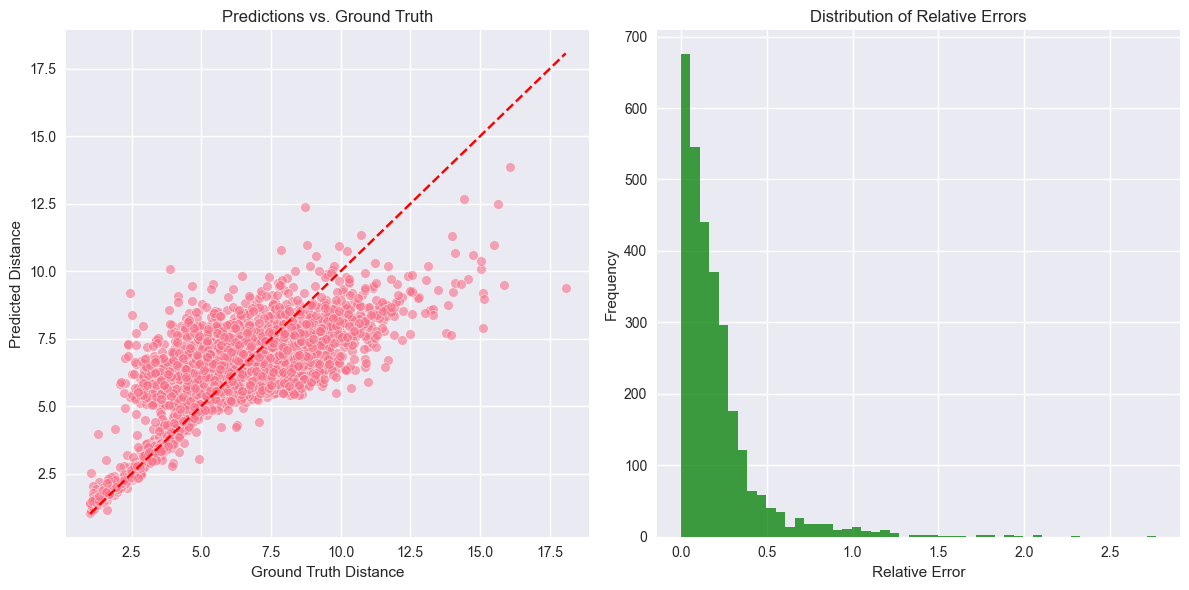


--- Testing with Custom Example ---
Start node: 0, End node: 5
Predicted distance: 25.0764
True distance (Dijkstra): 9.0000


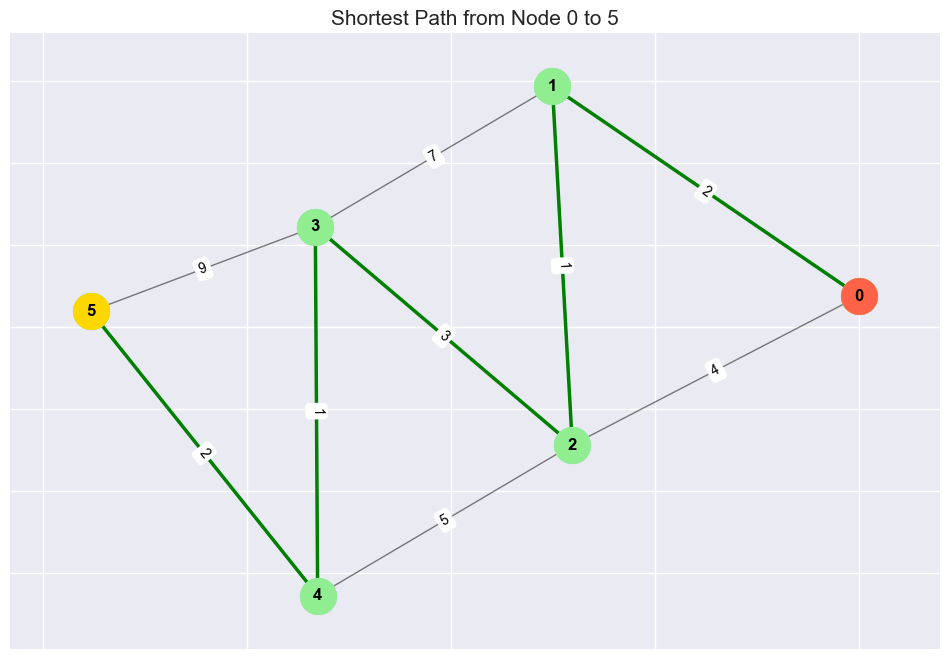


Final model saved as 'final_gnn_model.pth'


In [157]:
if __name__ == "__main__":
    predictor_instance = main()


--- Visualizing Dataset Sample #100 ---


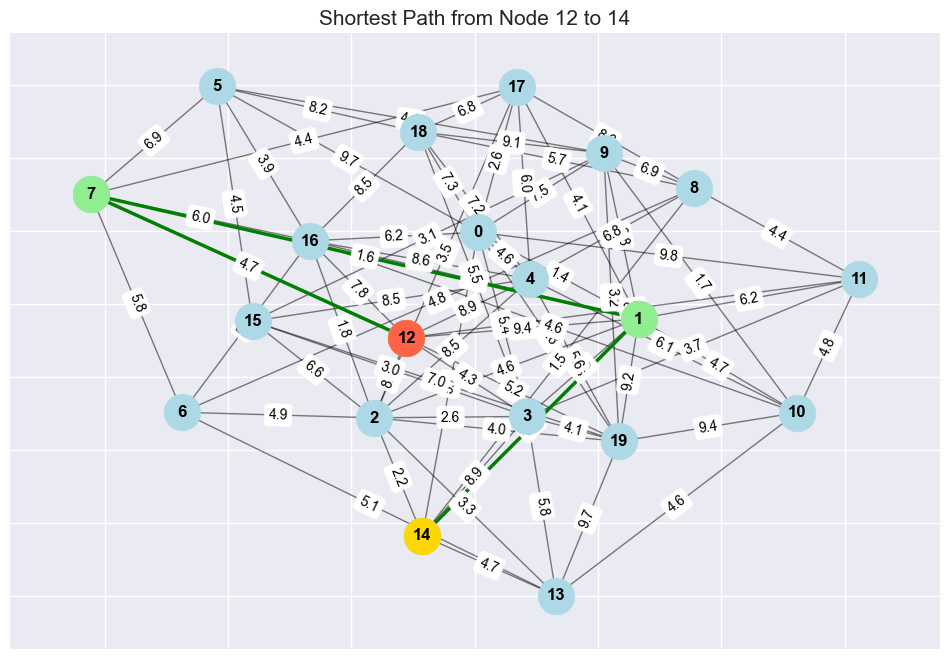


--- Visualizing Dataset Sample #103 ---


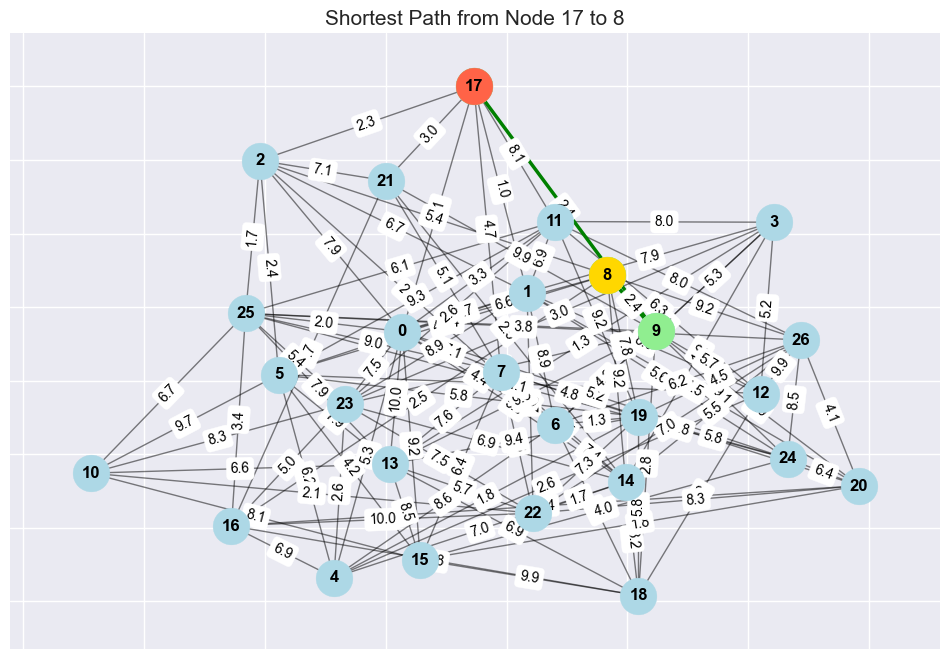


--- Visualizing Dataset Sample #106 ---


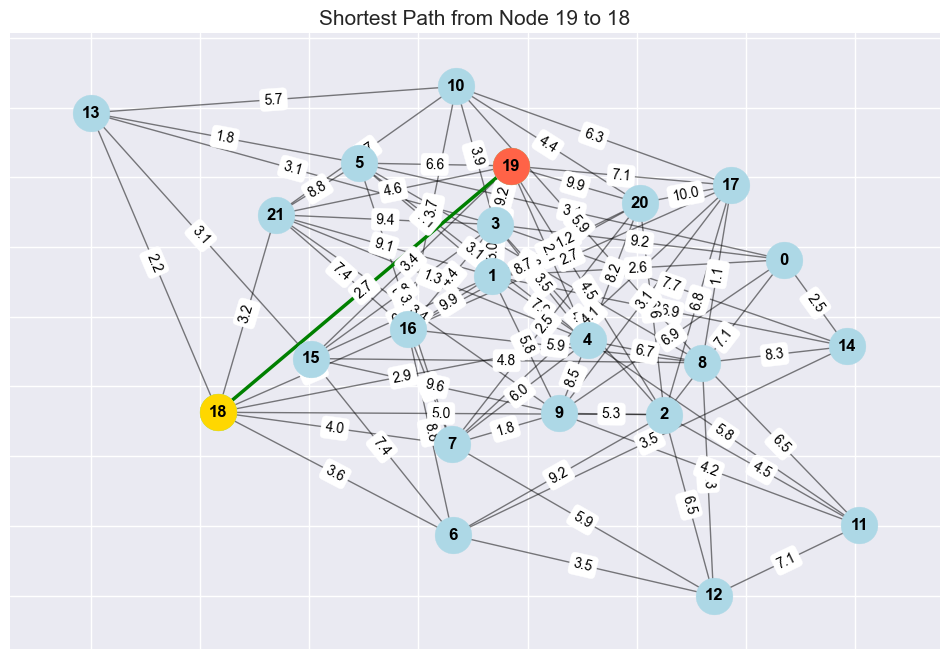


--- Visualizing Dataset Sample #109 ---


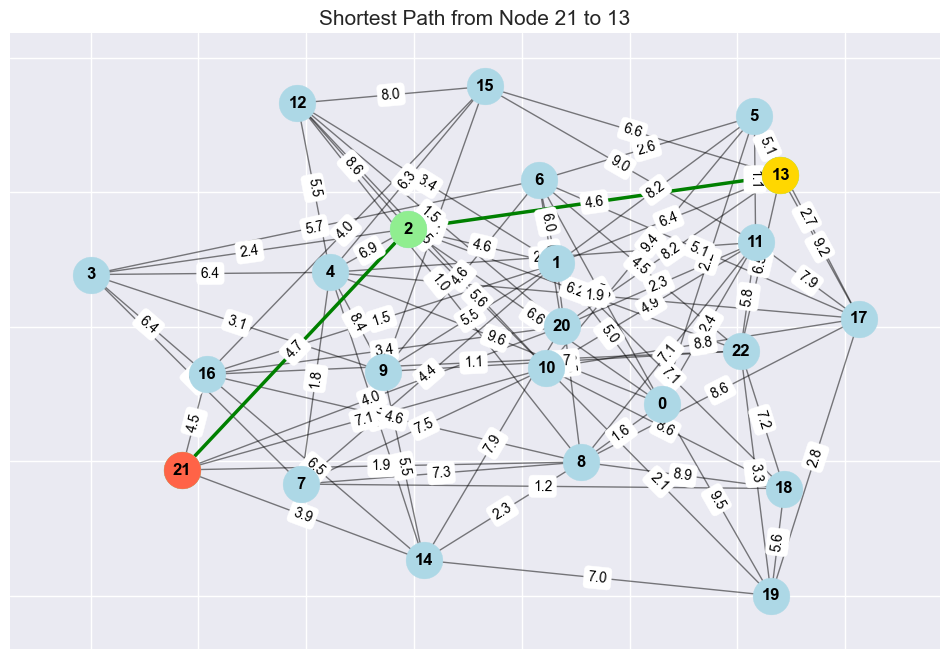


--- Visualizing Dataset Sample #112 ---


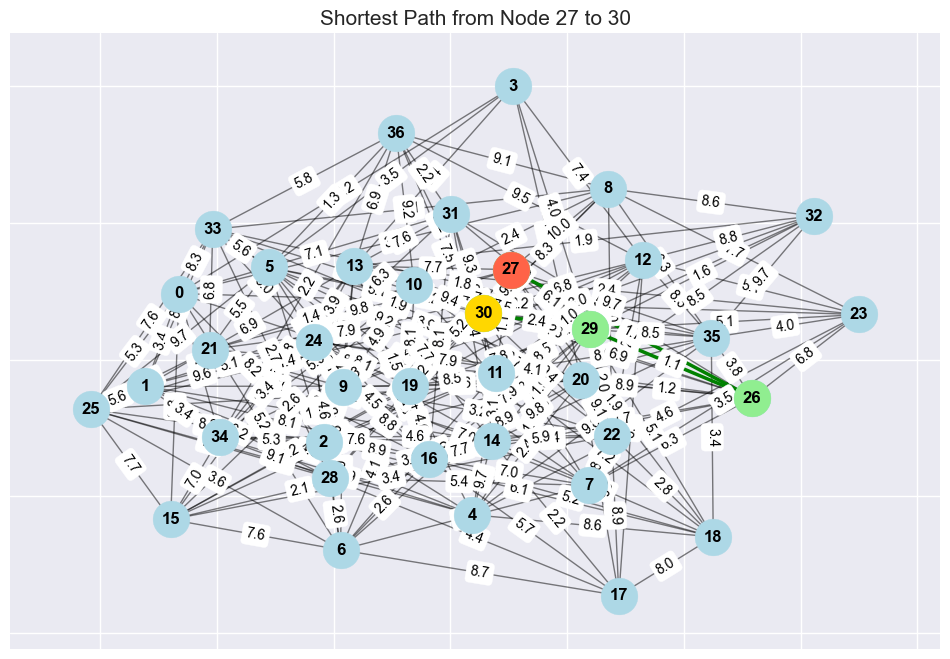


--- Visualizing Dataset Sample #115 ---


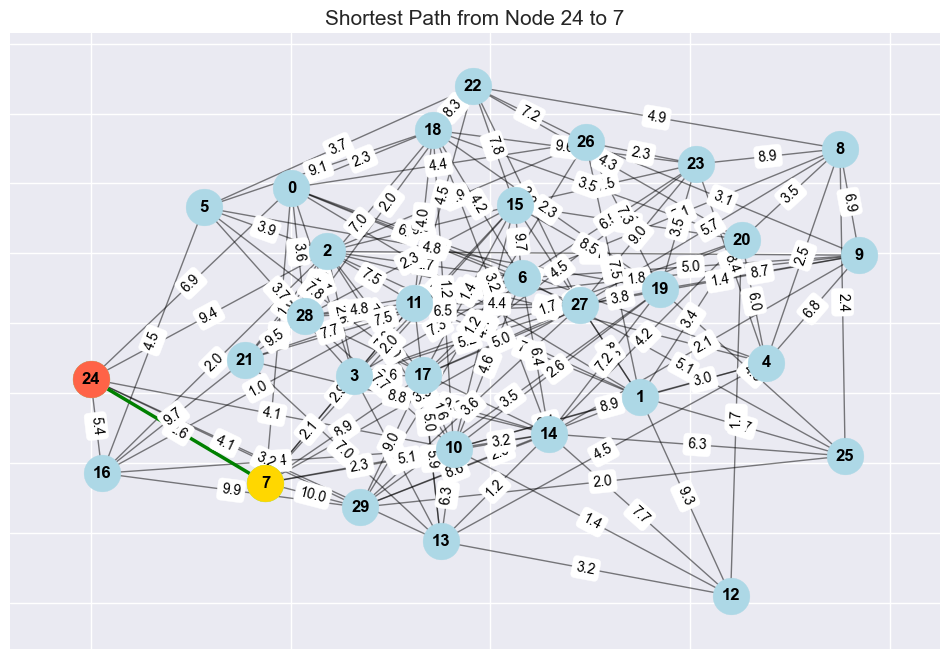


--- Visualizing Dataset Sample #118 ---


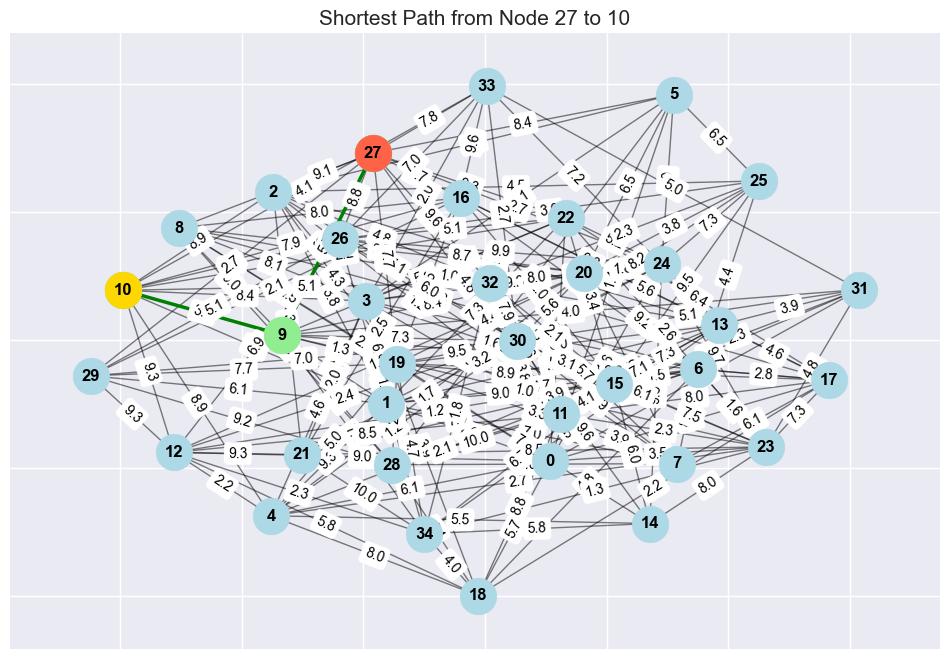


--- Visualizing Dataset Sample #121 ---


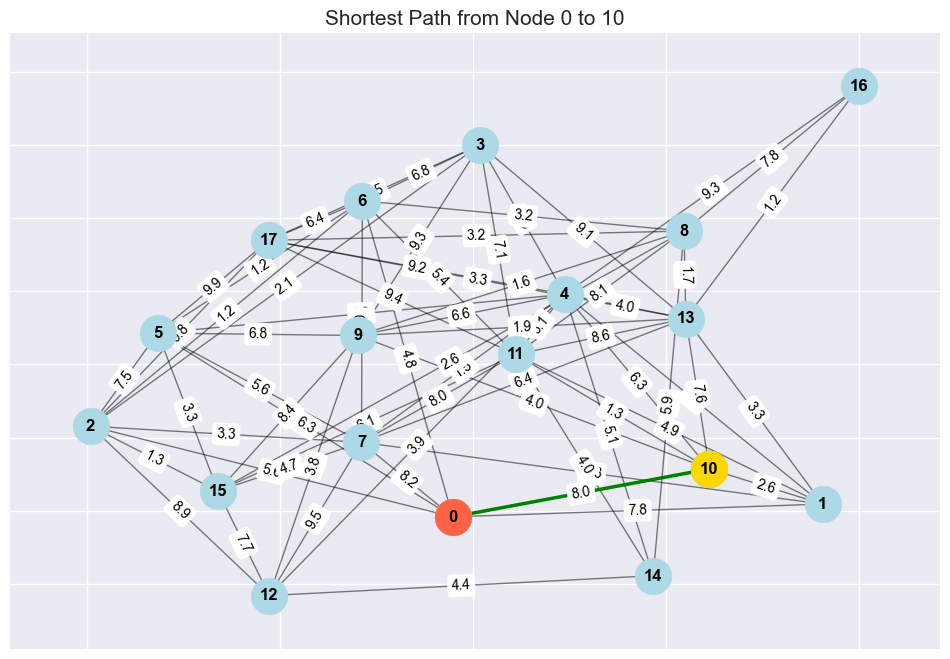


--- Visualizing Dataset Sample #124 ---


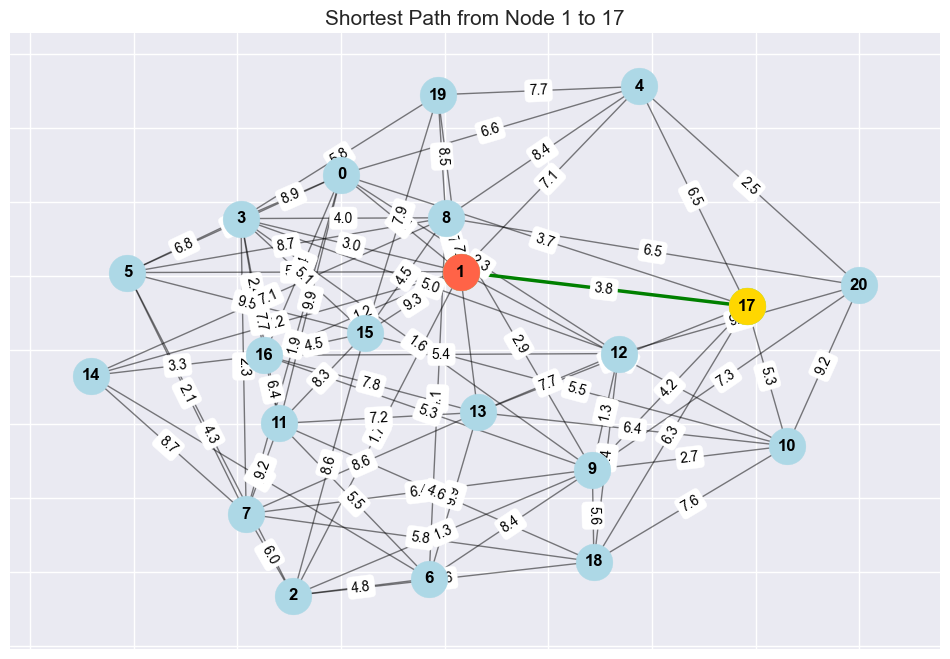


--- Visualizing Dataset Sample #127 ---


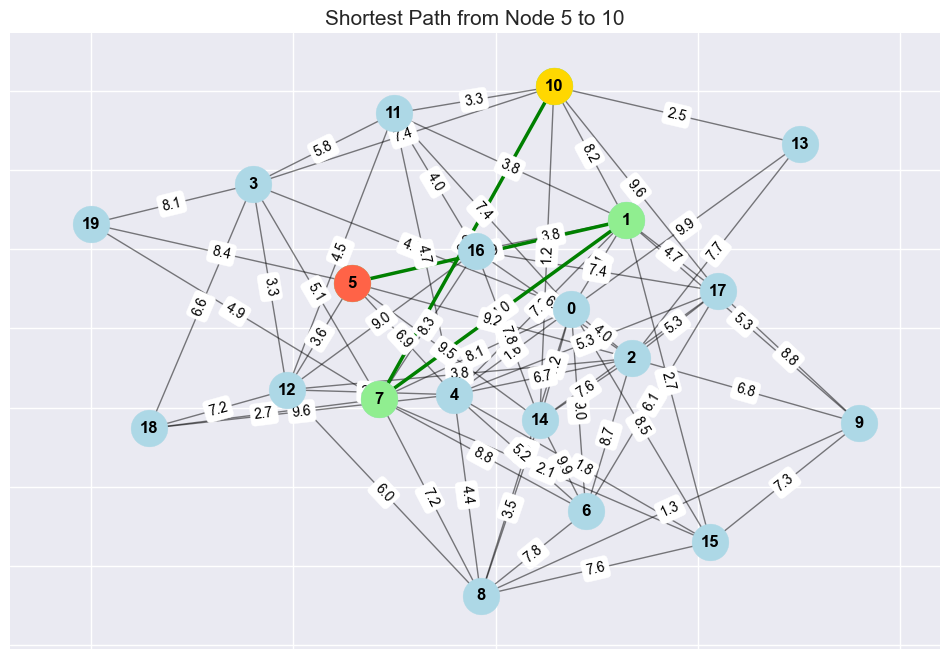


--- Visualizing Dataset Sample #130 ---


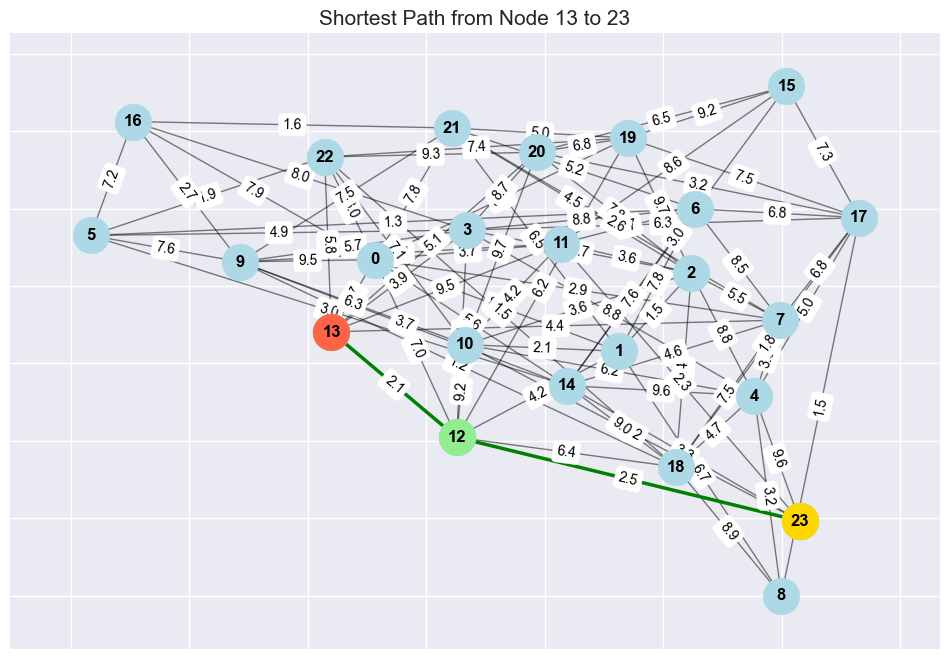


--- Visualizing Dataset Sample #133 ---


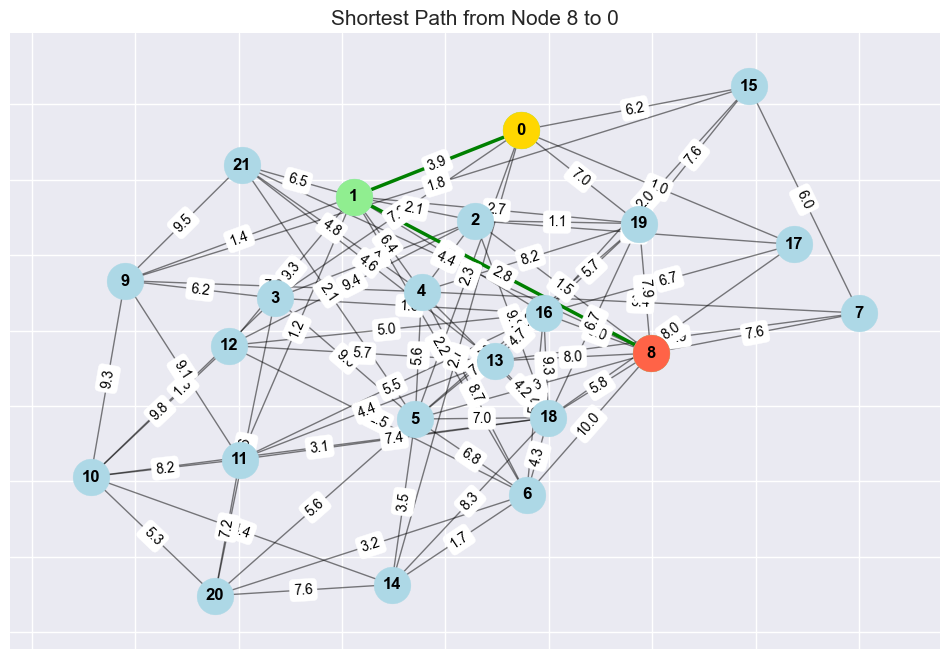


--- Visualizing Dataset Sample #136 ---


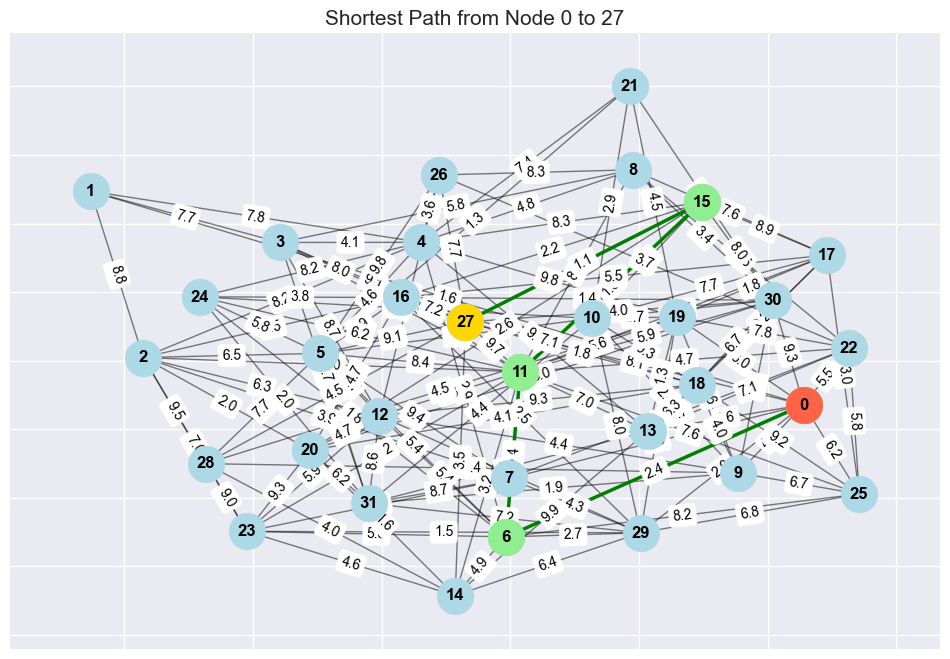


--- Visualizing Dataset Sample #139 ---


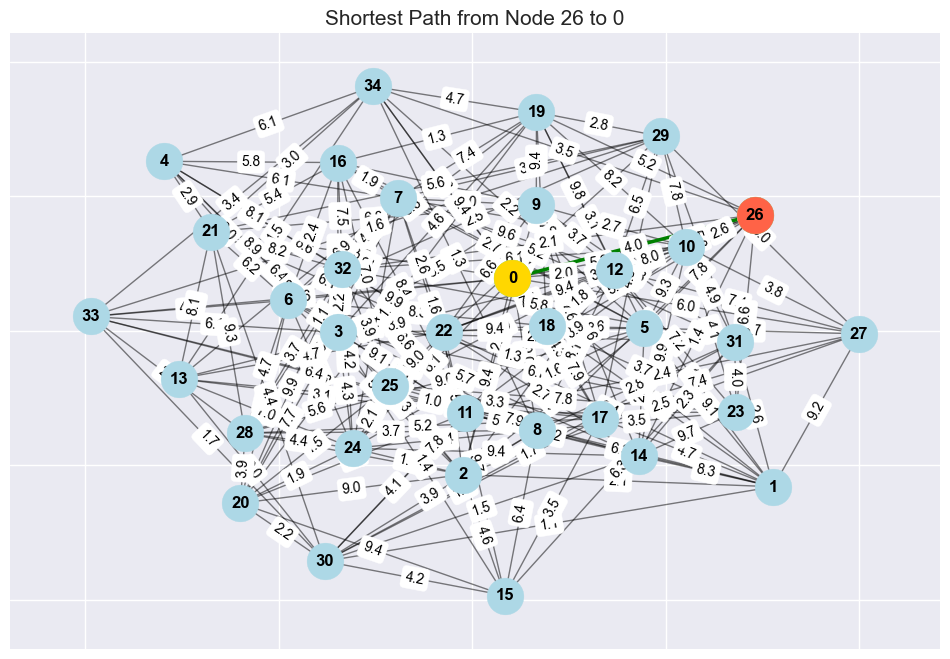


--- Visualizing Dataset Sample #142 ---


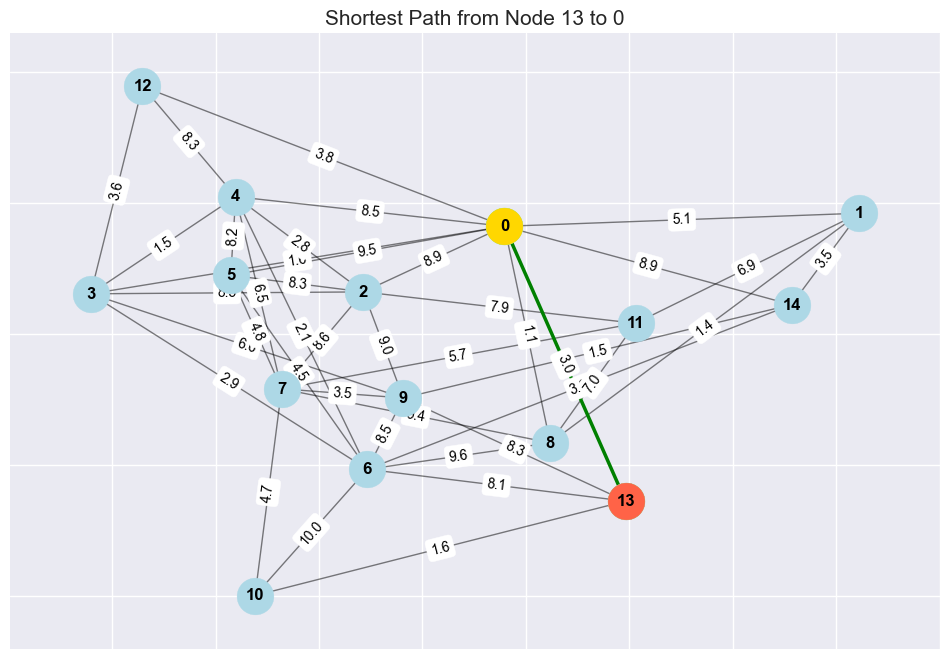


--- Visualizing Dataset Sample #145 ---


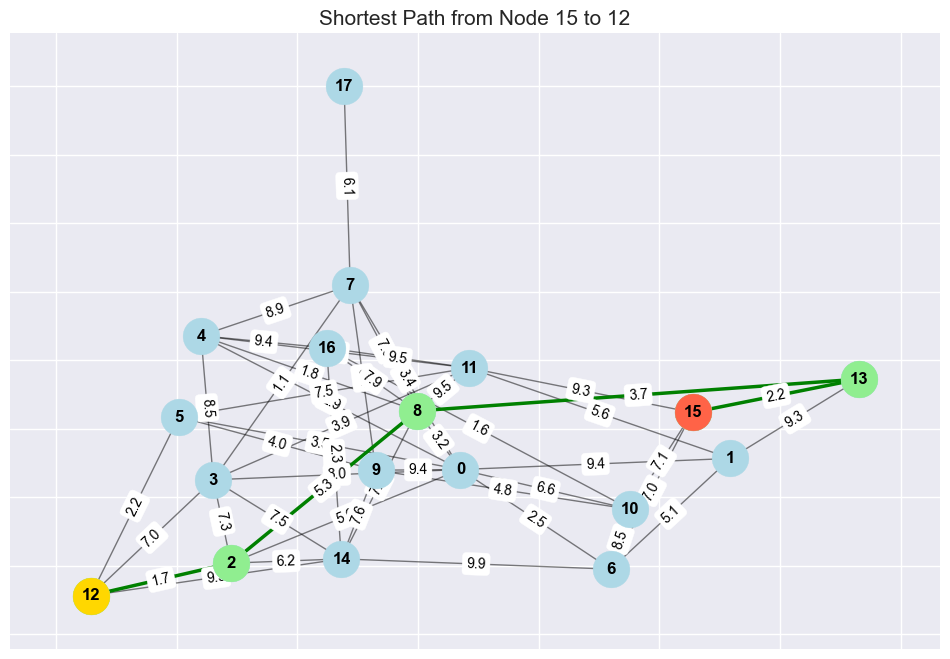


--- Visualizing Dataset Sample #148 ---


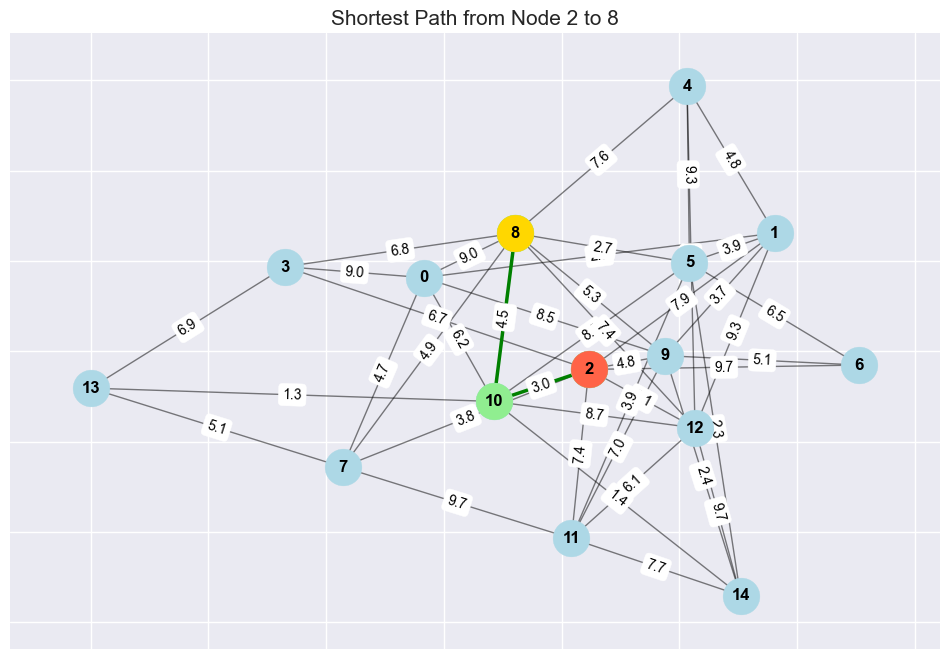


--- Visualizing Dataset Sample #151 ---


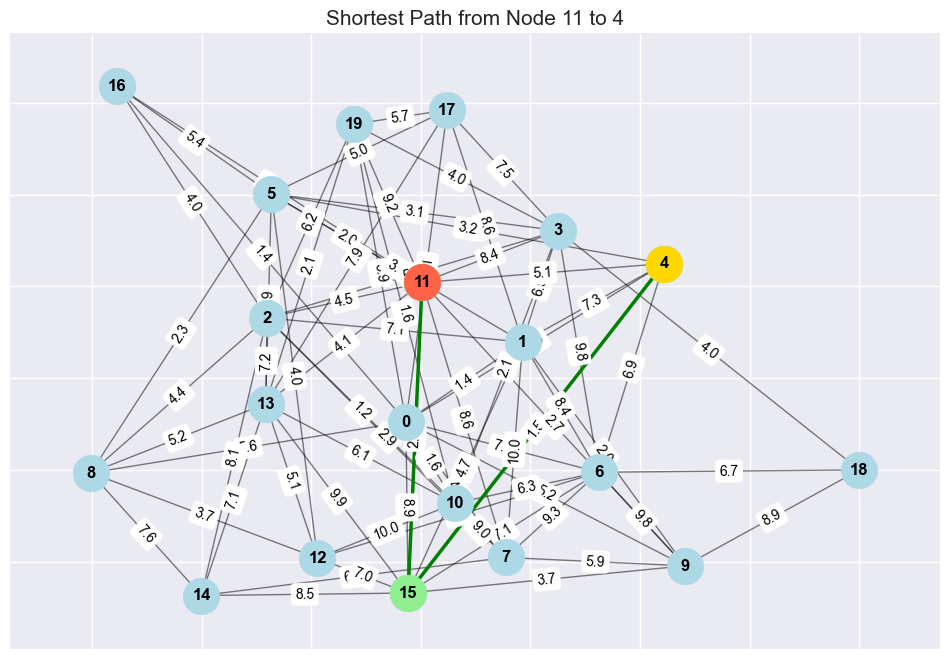


--- Visualizing Dataset Sample #154 ---


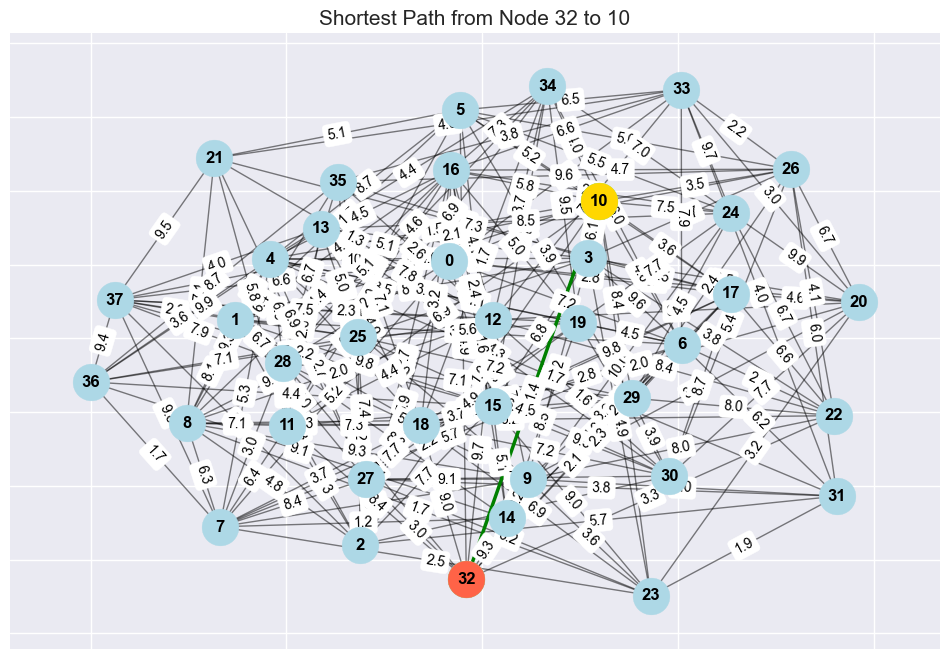


--- Visualizing Dataset Sample #157 ---


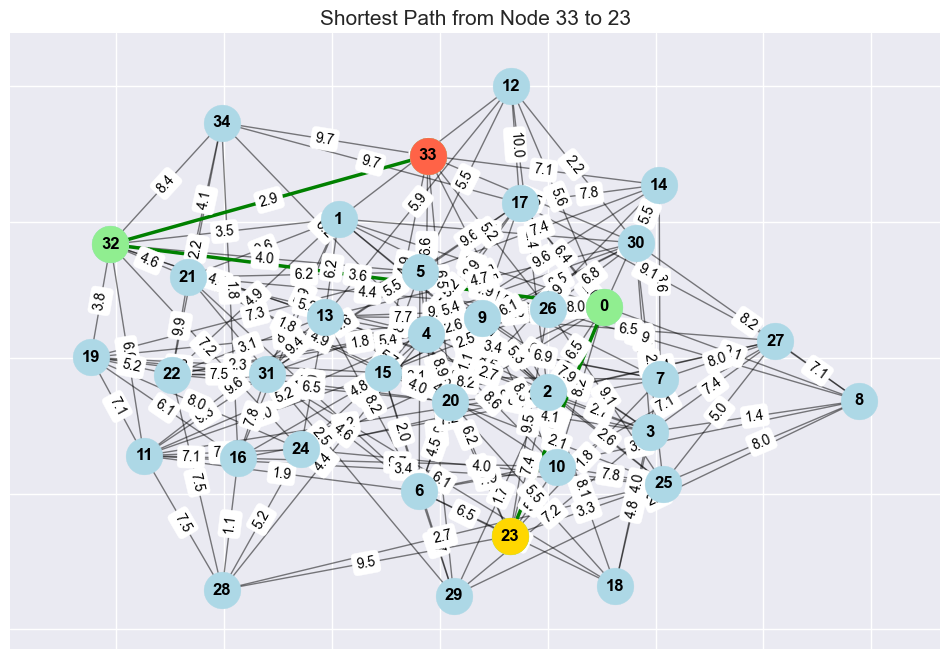

In [161]:
for i in range(20):
    predictor_instance.visualize_dataset_sample(index=100+ i*3)

In [162]:
sample_adj_matrix = np.array([
    [0, 1, 5, 0, 0],
    [1, 0, 2, 4, 0],
    [5, 2, 0, 1, 6],
    [0, 4, 1, 0, 3],
    [0, 0, 6, 3, 0],
], dtype=np.float32)

In [166]:
predicted_dist, true_dist, true_path = predictor_instance.predict_path(sample_adj_matrix, 0, 4)
print(predicted_dist , '\n',true_dist, '\n', true_path,'\n')

26.096763610839844 
 7.0 
 [0, 1, 2, 3, 4] 



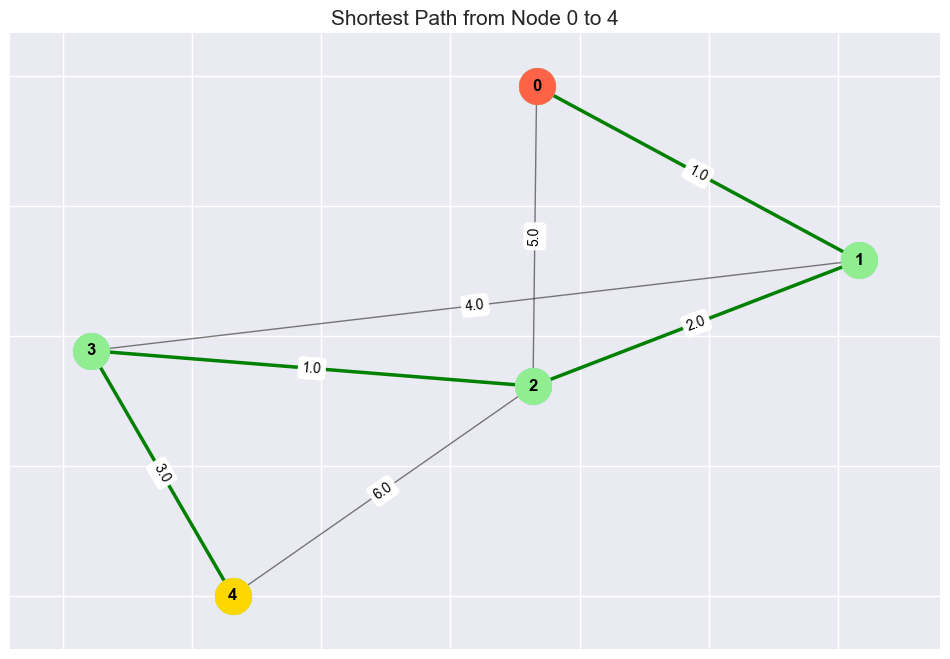

In [168]:
predictor_instance.plot_graph_with_path(sample_adj_matrix, 0, 4,true_path)